In [1]:
import numpy as np
import matplotlib.pyplot as plt

from stacked_mnist import StackedMNISTData, DataMode
from models.auto_encoder import AutoEncoder
from models.mnist_classifier import MNISTClassifier

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from utils import *

In [2]:
# Using the provided mnist dataset class
gen = StackedMNISTData(mode=DataMode.MONO_BINARY_MISSING, default_batch_size=9)

train_data = gen.get_full_data_set(training=True)
test_data = gen.get_full_data_set(training=False)

In [3]:
train_data[0].shape, test_data[0].shape

((54149, 28, 28, 1), (10000, 28, 28, 1))

(54149, 28, 28, 1) (54149,)
(10000, 28, 28, 1) (10000,)
(28, 28, 1)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
9


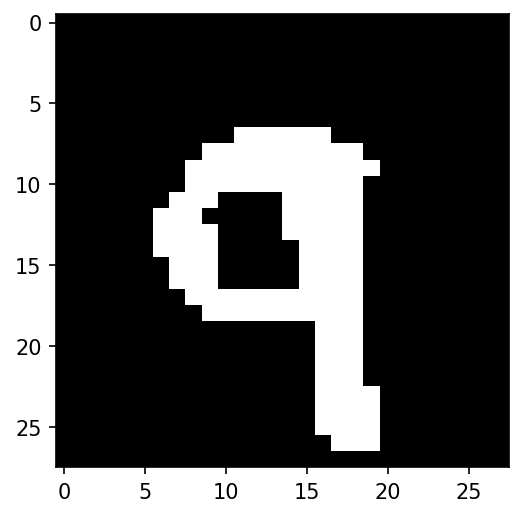

In [4]:
x_train, y_train = train_data
x_test, y_test = test_data
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Convert y_train and y_test into one-hot vectors
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)

rand = np.random.randint(0, x_train.shape[0])
img = x_train[rand]
label = y_train[rand]
print(img.shape)

print(label)
print(label.argmax())
plt.figure(figsize=(6, 4), dpi=150)
plt.imshow(img.squeeze(), cmap="gray")

In [5]:
# Create pytorch dataloaders from x_test and y_test
x_test = torch.from_numpy(x_test.astype(np.float32)).permute(0, 3, 1, 2)
y_test = torch.from_numpy(y_test.astype(np.float32))

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [7]:
test_loader_1 = DataLoader(test_dataset, batch_size=1)

In [8]:
model = AutoEncoder(1)
model.load_state_dict(torch.load('trained_models/auto_encoder_missing.pt', map_location=torch.device('cpu')))
model.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=512, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(128, 2, 2))
    (5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(64, 32, kernel_size=(3, 3)

In [9]:
# Get anomalous images - save the eight images with the highest loss as anomalous
model.eval()

criterion = nn.BCELoss()

anomalous_images = []
max_losses = []
labels = []

with torch.no_grad():
    for x, y in test_loader_1:
        y = y.argmax(dim=1).item()
        x = x.to(device)
        pred = model(x)
        loss = criterion(pred, x)
        loss = loss.item()
        if len(max_losses) > 7:
            min_val = min(max_losses)
            min_loss_index = max_losses.index(min_val)
            if (loss > min_val): 
                anomalous_images[min_loss_index] = pred.squeeze(0).cpu().numpy()
                max_losses[min_loss_index] = loss
                labels[min_loss_index] = y
        else:
            anomalous_images.append(pred.squeeze(0).cpu().numpy())
            max_losses.append(loss)
            labels.append(y)


Test accuracy with classifier

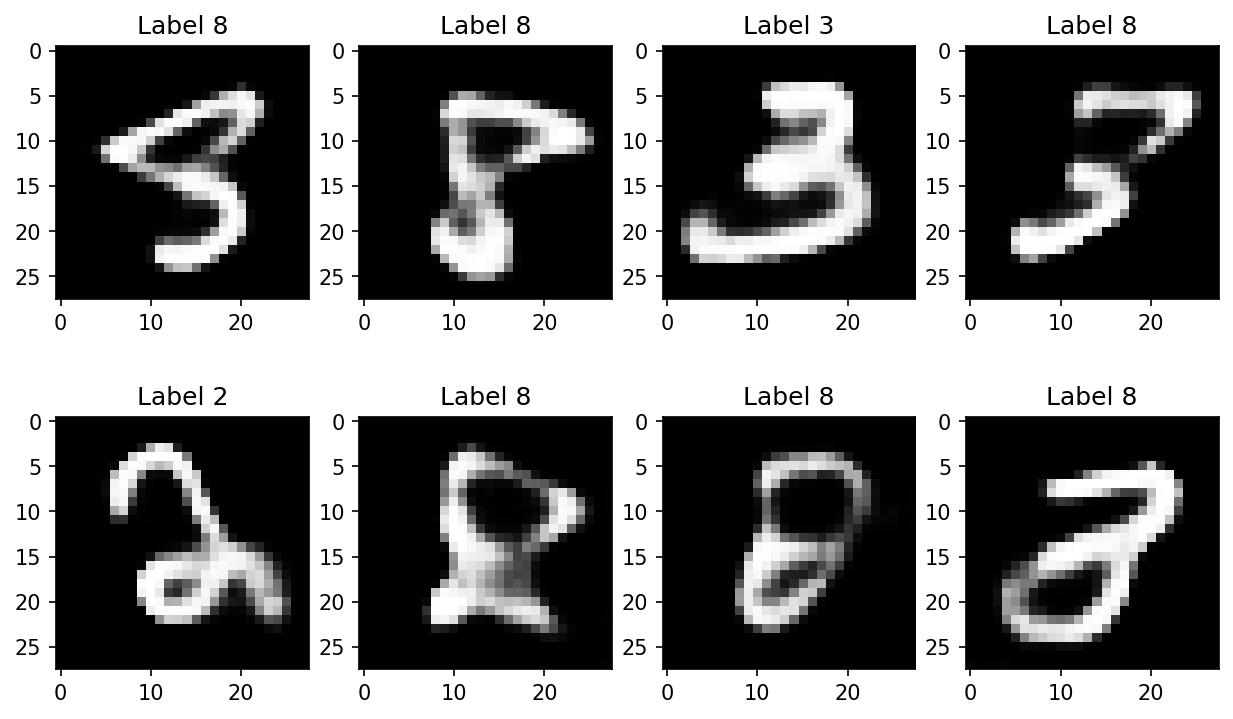

In [10]:
# Create a figure with 5 horizontally arranged subplots
fig, axs = plt.subplots(2, 4, figsize=(10, 6), dpi=150)

# Plot each image in a separate subplot
n = 0
for i in range(2):
    for j in range(4):
        axs[i, j].imshow(anomalous_images[n].squeeze(), cmap='gray')
        axs[i, j].set_title(f"Label {labels[n]}")
        n += 1
    
plt.show()

We can see that it filters out a lot of the eights, but unfortunately also some other numbers